 give an image plane (HxW) with multiple AoI (e.g. pick_i, place_i) ,

 generate random points localted in the image plane to simulate the potential gaze,
  
 the generate the point should be in time series and mainly spread around the AoI (e.g.) first splatter around point1, then place1, then pick2, then place2)

In [214]:
import numpy as np
import matplotlib.pyplot as plt

### Simulate Gaze Data

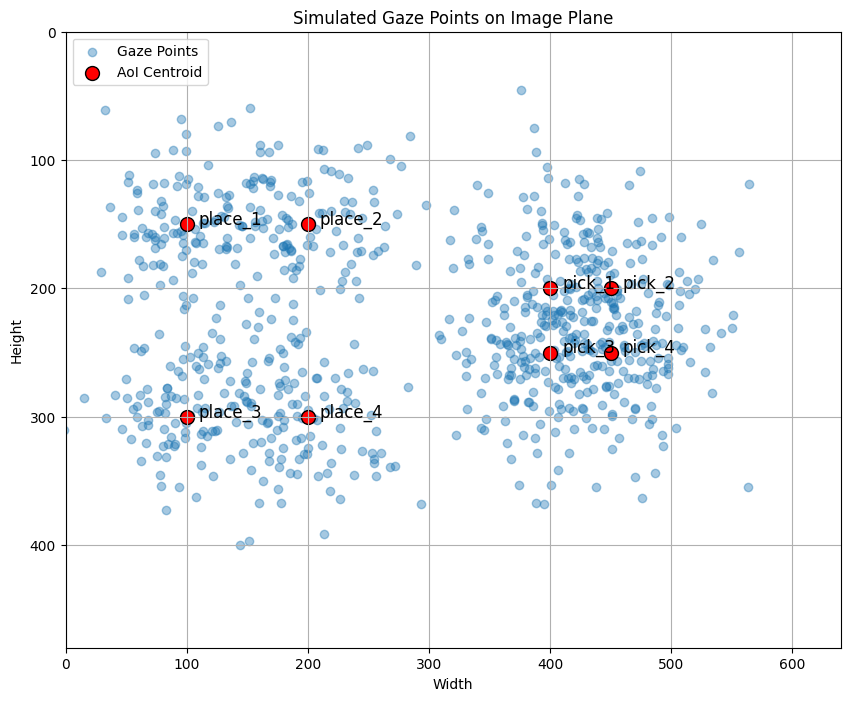

In [215]:
# Define the parameters for the image plane and AoIs
image_height = 480  # Height of the image
image_width = 640   # Width of the image
num_points = 100    # Number of points to generate around each AoI

# AoIs defined as tuples of (center_x, center_y, spread)

# # # case one
# AoIs = {
#     'pick_1': (400, 150, 45),
#     'place_1': (100, 150, 35),

#     'pick_2': (500, 150, 45),
#     'place_2': (200, 150, 35),

#     'pick_3': (400, 300, 45),
#     'place_3': (100, 300, 35),

#     'pick_4': (500, 300, 45),    
#     'place_4': (200, 300, 35)
# }

# case two
AoIs = {
    'pick_1': (400, 200, 45),
    'place_1': (100, 150, 35),

    'pick_2': (450, 200, 45),
    'place_2': (200, 150, 35),

    'pick_3': (400, 250, 45),
    'place_3': (100, 300, 35),

    'pick_4': (450, 250, 45),    
    'place_4': (200, 300, 35)
}

# Function to generate gaze points around a given AoI
def generate_points(center_x, center_y, spread, num_points):
    x_points = np.random.normal(loc=center_x, scale=spread, size=num_points)
    y_points = np.random.normal(loc=center_y, scale=spread, size=num_points)
    return np.column_stack((x_points, y_points))

# Container for all points
gaze_points_arr = []

# Generate points for each AoI and store them in an array
for AoI, (x, y, spread) in AoIs.items():
    points = generate_points(x, y, spread, num_points)
    gaze_points_arr.extend(points)

# Plot the points
plt.figure(figsize=(10, 8))
gaze_points_arr = np.array(gaze_points_arr) # list --> nparr
plt.scatter(gaze_points_arr[:, 0], gaze_points_arr[:, 1], alpha=0.4, label='Gaze Points')
# plt.scatter(all_x_points, all_y_points, alpha=0.6, label='Gaze Points')


# Plotting the AoI centers and labeling directly next to the point
for AoI, (x, y, spread) in AoIs.items():
    plt.scatter(x, y, color='red', s=100, edgecolors='black', label='AoI Centroid' if 'pick_1' == AoI else "")
    plt.text(x + 10, y, AoI, fontsize=12, color='black')  # Position labels close to AoI centers


plt.xlim(0, image_width)
plt.ylim(0, image_height)
plt.gca().invert_yaxis()  # Invert the y-axis to match typical image coordinates
plt.title('Simulated Gaze Points on Image Plane')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# plot the real mean, over the calculated mean of the estimated point

### Calculate the likelihood of AoI_i given gaze point, gi

Calcualte the likelihood P(AoI_1|gt),

the way to calculate it is to find the distance from the point to AoI and calculate the overal 2d gaussian correpondingly

In [216]:
from scipy.stats import multivariate_normal
def compute_normalized_likelihoods(AoIs, gaze_points_arr, state=None):
    """
    Compute normalized likelihoods for gaze points relative to specified AoIs.
    
    Args:
    AoIs (dict): Dictionary containing keys with 'pick' or 'place' and their coordinates.
    gaze_points_arr (np.array): Array of gaze points.
    state (str): Filter term to select either 'pick' or 'place' coordinates from AoIs.
    
    Returns:
    np.array: Normalized likelihood matrix for each gaze point to each AoI.
    """
    if state is not None:
        # Filter coordinates by state if specified
        coordinates = {key: value[:2] for key, value in AoIs.items() if state in key}
    else:
        # Include all coordinates if no state is specified
        coordinates = {key: value[:2] for key, value in AoIs.items()}
    
    # # Extract the x and y coordinates based on the filter term
    # coordinates = {key: value[:2] for key, value in AoIs.items() if state in key}
    
    # Convert the dictionary values (coordinates) into a NumPy array
    block_positions = np.array(list(coordinates.values()))
    
    # Normalize these positions along with the gaze points
    print(block_positions)
    all_positions = np.concatenate((block_positions, gaze_points_arr), axis=0)
    min_vals = np.min(all_positions, axis=0)
    max_vals = np.max(all_positions, axis=0)
    scaled_blocks = (block_positions - min_vals) / (max_vals - min_vals)
    scaled_gazes = (gaze_points_arr - min_vals) / (max_vals - min_vals)
    
    # Covariance matrix (suitably adjusted for the scaled data)
    covariance_matrix = np.diag([0.05**2, 0.05**2])
    
    # Initialize a matrix to hold probabilities
    likelihood = np.zeros((len(gaze_points_arr), len(block_positions)))
    
    # Compute probabilities for each normalized gaze point
    for i, g_i in enumerate(scaled_gazes):
        gaze_distribution = multivariate_normal(mean=g_i, cov=covariance_matrix)
        likelihood[i, :] = [gaze_distribution.pdf(block) for block in scaled_blocks]
    
    # Normalize each row of the probabilities matrix
    normalized_probabilities = likelihood / likelihood.sum(axis=1, keepdims=True)  # sum to 1
    
    return normalized_probabilities

### 1. Compute Probability + Confusion for Baseline (likehood = intent probability)

In [217]:
import numpy as np
import matplotlib.pyplot as plt
def plot_aoi_likelihoods_over_time(normalized_probabilities, aois=None):
    """
    Plots the likelihood of each Area of Interest (AoI) over time based on given normalized probabilities.
    
    Parameters:
    - normalized_probabilities (np.ndarray): A 2D numpy array where each row represents a time point
      and each column represents the probability of a specific AoI.
    - aois (list of str): Optional. Names of the AoIs corresponding to each column in normalized_probabilities.
    """
    # Determine the number of time points
    time_points = np.arange(normalized_probabilities.shape[0])
    
    # Determine the number of AoIs and their labels
    num_aois = normalized_probabilities.shape[1]
    if aois is None:
        aois = [f'AoI_{i + 1}' for i in range(num_aois)]
    
    # Check if aois list matches the number of columns in normalized_probabilities
    if len(aois) != num_aois:
        raise ValueError("Length of 'aois' must match the number of columns in 'normalized_probabilities'.")
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    for block_index in range(num_aois):
        plt.plot(time_points, normalized_probabilities[:, block_index], label=aois[block_index])

    # Adding plot elements
    plt.xlabel('Time (t)')
    plt.ylabel('Probability P(AOI_i | g_i)')
    plt.title('Likelihood of AoI Given Gaze Over Time')
    plt.legend(title="Intents")
    plt.grid(True)
    plt.show()

[[400 200]
 [450 200]
 [400 250]
 [450 250]]


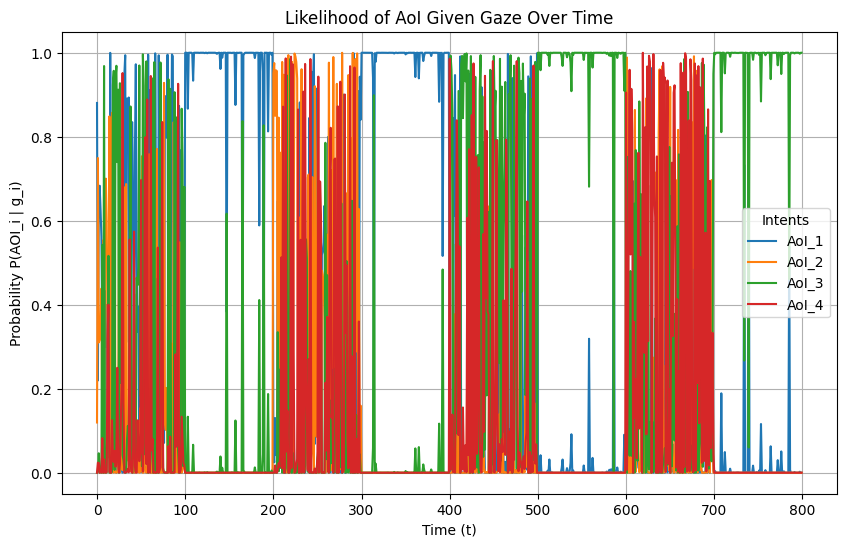

In [218]:


# compute the probability == likelihood in this case
normalized_probabilities = compute_normalized_likelihoods(AoIs, gaze_points_arr, state='pick')
plot_aoi_likelihoods_over_time(normalized_probabilities)



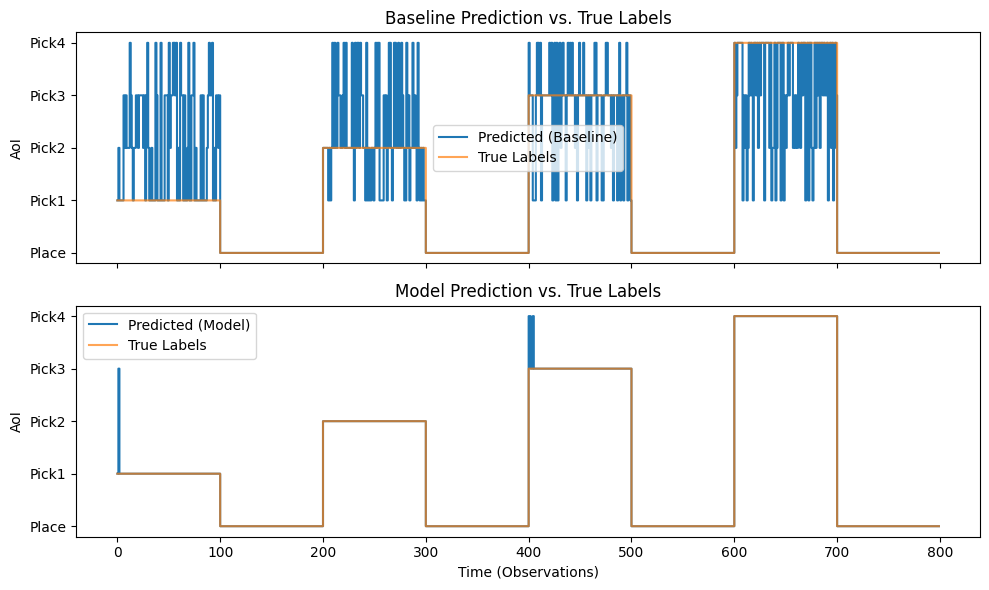

In [219]:

######### PRED LABEL (800x1)
# Compute predicted labels: the index of the maximum probability in each row (Nx1)
predicted_labels = np.argmax(normalized_probabilities, axis=1) + 1  # Shift index from 0-3 to 1-4

# Set both true_labels and predicted_labels to 0 outside of specified interest intervals
interest_intervals = [(0, 99), (200, 299), (400, 499), (600, 699)]

predicted_labels_outside_intervals = np.ones_like(predicted_labels, dtype=bool) # Set predicted_labels to 0 outside of interest intervals
for start, end in interest_intervals:
    predicted_labels_outside_intervals[start:end+1] = False  # Mark intervals of interest with False
predicted_labels[predicted_labels_outside_intervals] = 0  # Set labels to 0 outside of interest intervals


######### TRUE LABEL (800x1)
# Initialize the true_labels array with a default label
true_labels = np.zeros(predicted_labels.shape[0], dtype=int)
# Assign labels according to specified intervals
true_labels[0:100] = 1   # Block 1: Points 0-100
true_labels[200:300] = 2 # Block 2: Points 200-300
true_labels[400:500] = 3 # Block 3: Points 400-500
true_labels[600:700] = 4 # Block 4: Points 600-700

# Creating a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Plotting baseline predictions
axes[0].plot(predicted_labels, drawstyle='steps-post', label='Predicted (Baseline)')
axes[0].plot(true_labels, drawstyle='steps-post', label='True Labels', alpha=0.7)
axes[0].set_title('Baseline Prediction vs. True Labels')
axes[0].set_ylabel('AoI')
axes[0].legend()

# Plotting model-based predictions
axes[1].plot(predicted_labels_2, drawstyle='steps-post', label='Predicted (Model)')
axes[1].plot(true_labels, drawstyle='steps-post', label='True Labels', alpha=0.7)
axes[1].set_title('Model Prediction vs. True Labels')
axes[1].set_xlabel('Time (Observations)')
axes[1].set_ylabel('AoI')
axes[1].legend()

# Set y-ticks for clarity
for ax in axes:
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(['Place', 'Pick1', 'Pick2', 'Pick3', 'Pick4'])

# Display the plot
plt.tight_layout()
plt.show()


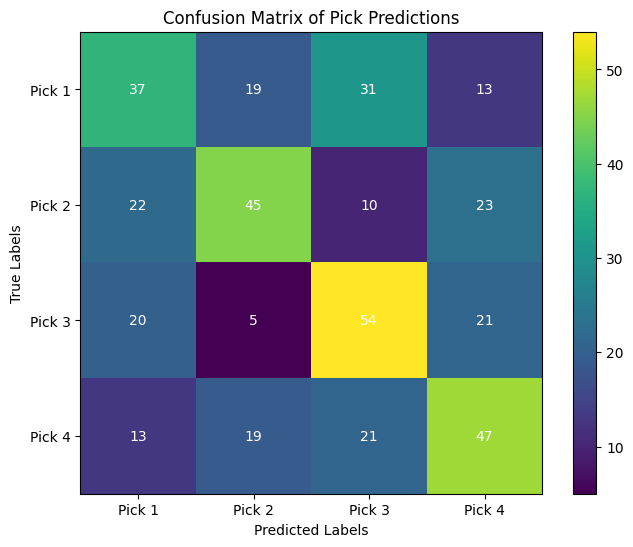

In [220]:


##### There are only total 4 labels of intereset:1,2,3,4 for the corresponding blocks (if label =0, we dont care), draw the confusion matrix based on the prediction and the true label
def compute_confusion_matrix(true, pred, num_classes=4):
    # Initialize the confusion matrix to all zeros
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Calculate the confusion matrix. Ignore instances where true label is 0.
    for t, p in zip(true, pred):
        if t > 0:  # Only consider cases where true label is 1-4
            conf_matrix[t-1, p-1] += 1
    
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='viridis', interpolation='none')
    plt.colorbar()  # Add a colorbar to a plot

    # Adding titles and labels
    plt.title('Confusion Matrix of Pick Predictions')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Adding grid lines for clarity
    plt.grid(False)  # Turn off the grid to avoid lines across the blocks

    # Annotating the heatmap with text
    num_classes = conf_matrix.shape[0]
    block_names = ['Pick 1', 'Pick 2', 'Pick 3', 'Pick 4']
    plt.xticks(ticks=np.arange(num_classes), labels=block_names)
    plt.yticks(ticks=np.arange(num_classes), labels=block_names)

    # Loop over data dimensions and create text annotations.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, conf_matrix[i, j],
                     ha="center", va="center", color="w")

    plt.show()


######## Calculate the confusion matrix + Plot
conf_matrix = compute_confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(conf_matrix)

### 2. Compute the result with bayesian filter with a sequence as prior

In [221]:
# NOTE: just by given state to state transition (a sequence, block 1 -> 2-> 3 ->4), without filtering, the state estimated state becomes much clearner
# previously hte likelihood decide the final probability of the intent, and the highest one are reported
#  markov chain

In [222]:
# just now, using the likelihood as the final prediction is just the baseline
# i want to add the prior knowledge about the desire block transition (from 1 to 2 to 3 to 4, each shouldve last for 100 gaze points, still the interval of interst)
# should using a bayesian model with the likelihood of AoI_i given g_i as input, output the intent estimation (the probability of block_1,..., block_$)

[[400 200]
 [450 200]
 [400 250]
 [450 250]]


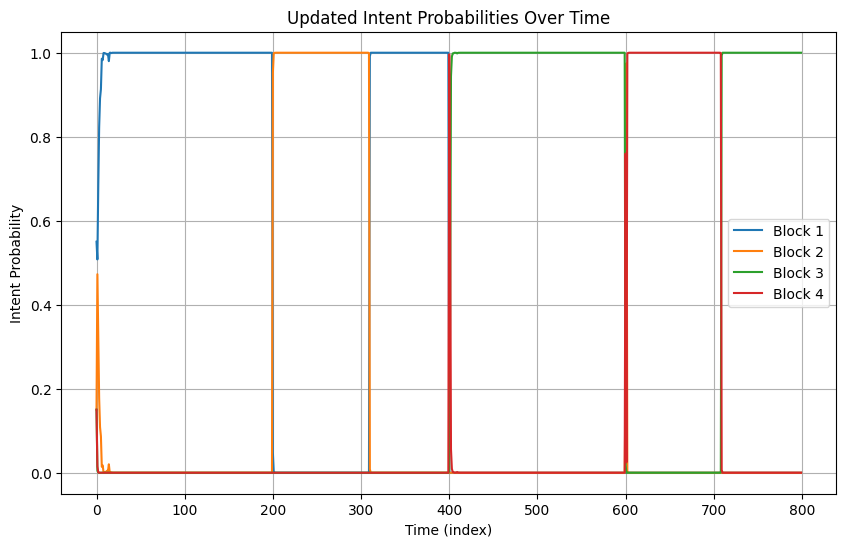

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Assuming compute_normalized_likelihoods is defined somewhere else and imported
normalized_likelihood = compute_normalized_likelihoods(AoIs, gaze_points_arr, 'pick')

interest_intervals = [(0, 99), (200, 299), (400, 499), (600, 699)]

# Transition matrix as defined earlier
transition_matrix = np.array([
    [0.15, 0.55, 0.15, 0.15],  # From Block 1, more likely to go to Block 2
    [0.15, 0.15, 0.55, 0.15],  # From Block 2, more likely to go to Block 3
    [0.15, 0.15, 0.15, 0.55],  # From Block 3, more likely to go to Block 4
    [0.55, 0.15, 0.15, 0.15]   # From Block 4, more likely to go back to Block 1 (looping back)
])

# Function to determine the current interval
def get_current_interval(time, intervals):
    for idx, (start, end) in enumerate(intervals):
        if start <= time < end:
            return idx
    return None

# Initialize state probabilities
state_probabilities = np.zeros((len(gaze_points_arr), 4))
# state_probabilities[0, :] = [0.85, 0.05, 0.05, 0.05]  # Assume starting with high chance at at Block 1
state_probabilities[0, :] = [0.55, 0.15, 0.15, 0.15]  # Assume starting with high chance at at Block 1

# Apply the update logic
last_interval_idx = get_current_interval(0, interest_intervals)  # Get the initial interval index

for i in range(1, len(gaze_points_arr)):
    current_interval_idx = get_current_interval(i, interest_intervals)

    # Check for transition at the start of a new interval
    if current_interval_idx is not None and current_interval_idx != last_interval_idx:
        state_probabilities[i] = transition_matrix @ state_probabilities[i - 1]
        last_interval_idx = current_interval_idx
    else:
        state_probabilities[i] = state_probabilities[i - 1]
    # if i % 50 == 0:
    #     # print(f'current time{i}, current interval{current_interval_idx}')
    # Multiply by normalized likelihood and normalize
    state_probabilities[i] *= normalized_likelihood[i]  # Check alignment with the likelihood data
    state_probabilities[i] /= np.sum(state_probabilities[i])  # Normalize to avoid computational issues

# Plot updated intent probabilities over time
plt.figure(figsize=(10, 6))
for block_index in range(4):
    plt.plot(state_probabilities[:, block_index], label=f'Block {block_index + 1}')
plt.xlabel('Time (index)')
plt.ylabel('Intent Probability')
plt.title('Updated Intent Probabilities Over Time')
plt.legend()
plt.grid(True)
plt.show()


(800,)


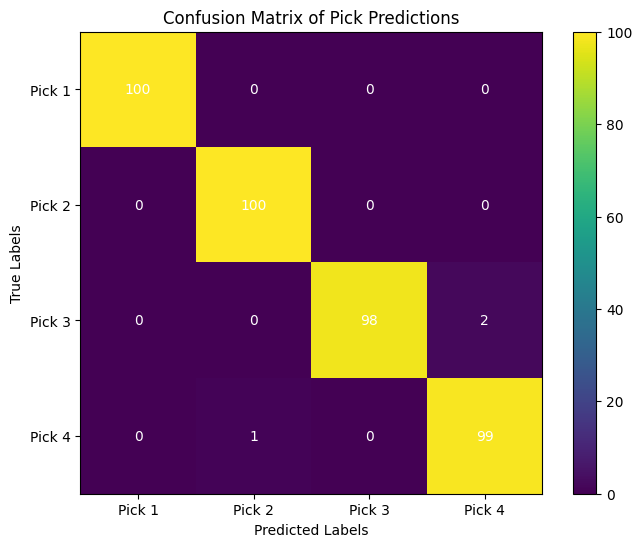

In [224]:
# Compute predicted labels: the index of the maximum probability in each row (Nx1)
predicted_labels_2 = np.argmax(state_probabilities, axis=1) + 1  # Shift index from 0-3 to 1-4
print(predicted_labels_2.shape)
# Set both true_labels and predicted_labels to 0 outside of specified interest intervals
interest_intervals = [(0, 99), (200, 299), (400, 499), (600, 699)]

predicted_labels_outside_intervals = np.ones_like(predicted_labels_2, dtype=bool) # Set predicted_labels to 0 outside of interest intervals
for start, end in interest_intervals:
    predicted_labels_outside_intervals[start:end+1] = False  # Mark intervals of interest with False
predicted_labels_2[predicted_labels_outside_intervals] = 0  # Set labels to 0 outside of interest intervals

conf_matrix = compute_confusion_matrix(true_labels, predicted_labels_2)
plot_confusion_matrix(conf_matrix)

## Build HMM model

In [225]:
import numpy as np
from hmmlearn import hmm

# Define the number of hidden states in the HMM
n_components = 8  # Example for 4 AoIs

# Initial transition matrix (you can start with your predefined matrix)
# initial_transition_matrix = np.array([
#     [0.15, 0.55, 0.15, 0.15],
#     [0.15, 0.15, 0.55, 0.15],
#     [0.15, 0.15, 0.15, 0.55],
#     [0.55, 0.15, 0.15, 0.15]
# ])
initial_transition_matrix = np.array([
    [0.15, 0.55, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.15, 0.55, 0.05, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.15, 0.55, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.15, 0.55, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.15, 0.55, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.15, 0.55, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.15, 0.55],
    [0.55, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.15]
])

observations =normalized_probabilities
# Create an HMM instance with Gaussian emissions
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)

# Initialize the transition matrix
model.transmat_ = initial_transition_matrix

# Fit the model to the data
model.fit(observations)

# # Now you can check the trained transition matrix and other parameters
# print("Trained transition matrix:")
# print(model.transmat_)

# # To predict states:
# states = model.predict(observations)
# print("Predicted states:")
# print(states)


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


GaussianHMM(n_components=8, n_iter=100)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


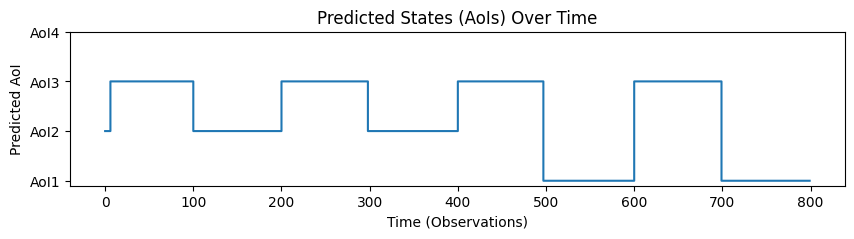

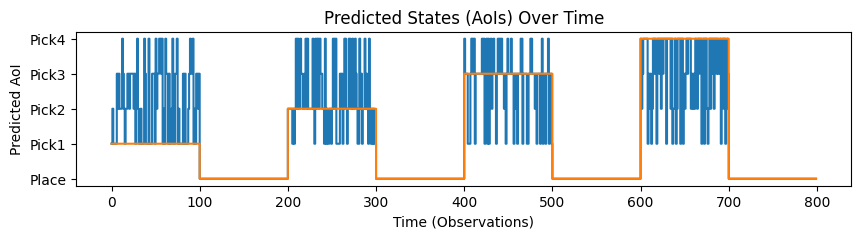

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Assume normalized_likelihood is your calculated likelihood matrix P(AoI_i|g_i)

# Convert likelihoods to integer indices of the most likely AoI
most_likely_states = np.argmax(normalized_likelihood, axis=1).reshape(-1, 1)

# Define the HMM
model = hmm.CategoricalHMM(n_components=4, n_iter=100, random_state=42)

# Example initial probabilities (uniform)
model.startprob_ = np.array([0.25, 0.25, 0.25, 0.25])

# Transition matrix with higher probabilities for moving to the next AoI
model.transmat_ = np.array([
    [0.2, 0.5, 0.15, 0.15],
    [0.15, 0.2, 0.5, 0.15],
    [0.15, 0.15, 0.2, 0.5],
    [0.5, 0.15, 0.15, 0.2]
])

# Emission probabilities (assuming equal because of random simulation)
model.emissionprob_ = np.tile(np.array([0.85, 0.05, 0.05, 0.05]), (4, 1))

# Fit the model to the most likely states derived from your likelihoods
model.fit(most_likely_states)

# Predict the hidden states (AoIs)
predicted_states = model.predict(most_likely_states)

# Plot the predicted states
plt.figure(figsize=(10, 2))
plt.plot(predicted_states, drawstyle='steps-post')
plt.title('Predicted States (AoIs) Over Time')
plt.xlabel('Time (Observations)')
plt.ylabel('Predicted AoI')
plt.yticks(np.arange(4), ['AoI1', 'AoI2', 'AoI3', 'AoI4'])
plt.show()

# Plot the predicted states
plt.figure(figsize=(10, 2))
plt.plot(predicted_labels, drawstyle='steps-post')
plt.plot(true_labels, drawstyle='steps-post')
plt.title('Predicted States (AoIs) Over Time')
plt.xlabel('Time (Observations)')
plt.ylabel('Predicted AoI')
plt.yticks(np.arange(5), ['Place','Pick1', 'Pick2', 'Pick3', 'Pick4'])
plt.show()

## NEW experiment


### Dataset

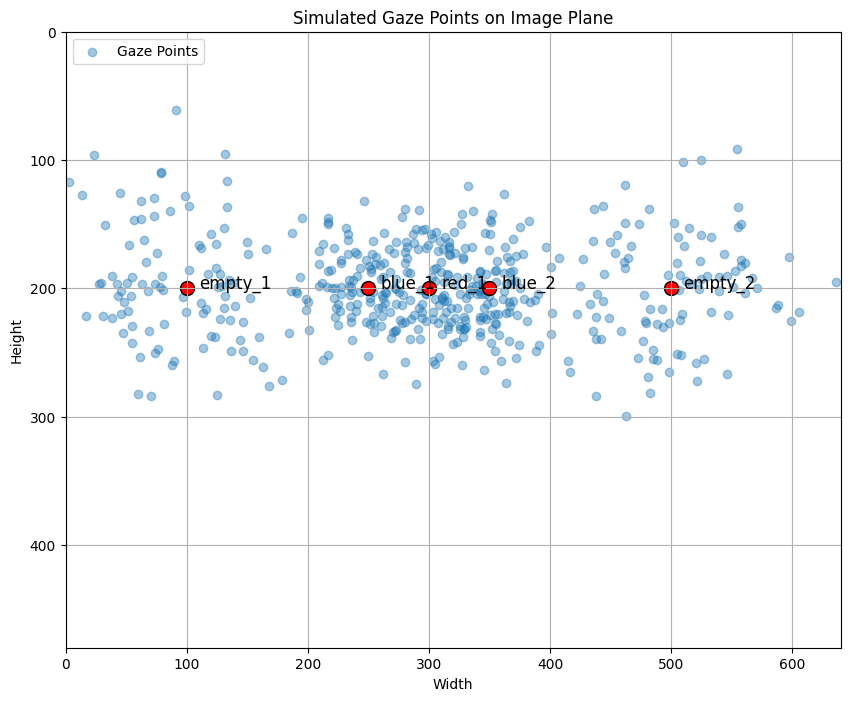

In [227]:
# Define the parameters for the image plane and AoIs
image_height = 480  # Height of the image
image_width = 640   # Width of the image
num_points = 100    # Number of points to generate around each AoI

# AoIs defined as tuples of (center_x, center_y, spread)

# case two
AoIs_3 = {
    'empty_1': (100, 200, 45),
    'blue_1': (250, 200, 30),
    'red_1': (300, 200, 30),
    'blue_2': (350, 200, 30),
    'empty_2': (500, 200, 45),
}

# Function to generate gaze points around a given AoI
def generate_points(center_x, center_y, spread, num_points):
    x_points = np.random.normal(loc=center_x, scale=spread, size=num_points)
    y_points = np.random.normal(loc=center_y, scale=spread, size=num_points)
    return np.column_stack((x_points, y_points))

# Container for all points
gaze_points_arr_3 = []

# Generate points for each AoI and store them in an array
for AoI, (x, y, spread) in AoIs_3.items():
    points = generate_points(x, y, spread, num_points)
    gaze_points_arr_3.extend(points)

# Plot the points
plt.figure(figsize=(10, 8))
gaze_points_arr_3 = np.array(gaze_points_arr_3) # list --> nparr
plt.scatter(gaze_points_arr_3[:, 0], gaze_points_arr_3[:, 1], alpha=0.4, label='Gaze Points')
# plt.scatter(all_x_points, all_y_points, alpha=0.6, label='Gaze Points')


# Plotting the AoI centers and labeling directly next to the point
for AoI, (x, y, spread) in AoIs_3.items():
    plt.scatter(x, y, color='red', s=100, edgecolors='black', label='AoI Centroid' if 'pick_1' == AoI else "")
    plt.text(x + 10, y, AoI, fontsize=12, color='black')  # Position labels close to AoI centers


plt.xlim(0, image_width)
plt.ylim(0, image_height)
plt.gca().invert_yaxis()  # Invert the y-axis to match typical image coordinates
plt.title('Simulated Gaze Points on Image Plane')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# plot the real mean, over the calculated mean of the estimated point

### Baseline intent estimation

[[100 200]
 [250 200]
 [300 200]
 [350 200]
 [500 200]]


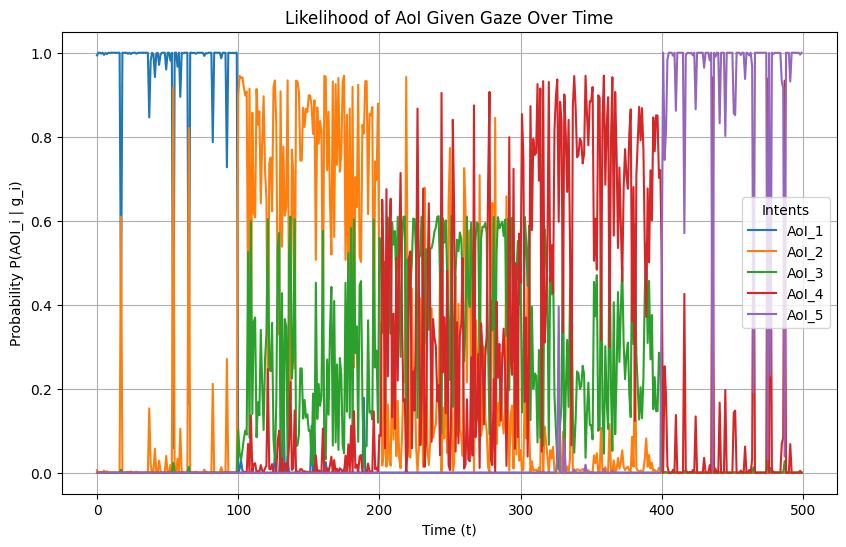

In [228]:
# print(gaze_points_arr_3.shape)
normalized_likelihood_3 = compute_normalized_likelihoods(AoIs_3, gaze_points_arr_3)
# predicted_labels_3 = 
plot_aoi_likelihoods_over_time(normalized_likelihood_3)


In [229]:
######### PRED LABEL (800x1)
# Compute predicted labels: the index of the maximum probability in each row (Nx1)
predicted_labels_3 = np.argmax(normalized_likelihood_3, axis=1) + 1  # Shift index from 0-3 to 1-4

# Set both true_labels and predicted_labels to 0 outside of specified interest intervals
interest_intervals = [(0, 99),(100, 199),  (200, 299), (300, 399), (400, 499)]

# predicted_labels_outside_intervals = np.ones_like(predicted_labels, dtype=bool) # Set predicted_labels to 0 outside of interest intervals
# for start, end in interest_intervals:
#     predicted_labels_outside_intervals[start:end+1] = False  # Mark intervals of interest with False
# predicted_labels[predicted_labels_outside_intervals] = 0  # Set labels to 0 outside of interest intervals


######### TRUE LABEL (800x1)
# Initialize the true_labels array with a default label
true_labels = np.zeros(predicted_labels_3.shape[0], dtype=int)
# Assign labels according to specified intervals
true_labels[0:100] = 1   # Block 1: Points 0-100
true_labels[100:200] = 2 # Block 2: Points 200-300
true_labels[200:300] = 3 # Block 2: Points 200-300
true_labels[300:400] = 4 # Block 2: Points 200-300
true_labels[400:500] = 5 # Block 3: Points 400-500

# # Creating a figure with two subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# # Plotting baseline predictions
# axes[0].plot(predicted_labels_3, drawstyle='steps-post', label='Predicted (Baseline)')
# axes[0].plot(true_labels, drawstyle='steps-post', label='True Labels', alpha=0.7)
# axes[0].set_title('Baseline Prediction vs. True Labels')
# axes[0].set_ylabel('AoI')
# axes[0].legend()

# # Plotting model-based predictions
# axes[1].plot(predicted_labels_2, drawstyle='steps-post', label='Predicted (Model)')
# axes[1].plot(true_labels, drawstyle='steps-post', label='True Labels', alpha=0.7)
# axes[1].set_title('Model Prediction vs. True Labels')
# axes[1].set_xlabel('Time (Observations)')
# axes[1].set_ylabel('AoI')
# axes[1].legend()

# # Set y-ticks for clarity
# for ax in axes:
#     ax.set_yticks(np.arange(5))
#     ax.set_yticklabels(['Place', 'Pick1', 'Pick2', 'Pick3', 'Pick4'])

# # Display the plot
# plt.tight_layout()
# plt.show()

Confusion Matrix:
[[97  3  0  0  0]
 [ 0 87 13  0  0]
 [ 0 15 60 25  0]
 [ 0  1 17 82  0]
 [ 0  0  0  5 95]]


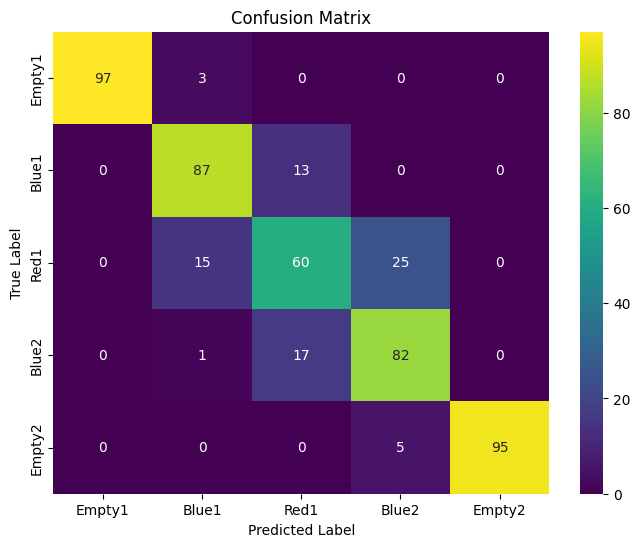

In [230]:
# conf_matrix = compute_confusion_matrix(true_labels, predicted_labels_3)
# plot_confusion_matrix(conf_matrix)
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Optional for better visualization

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_3)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["Empty1", "Blue1", "Red1", "Blue2","Empty2"], yticklabels=["Empty1", "Blue1", "Red1", "Blue2","Empty2"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


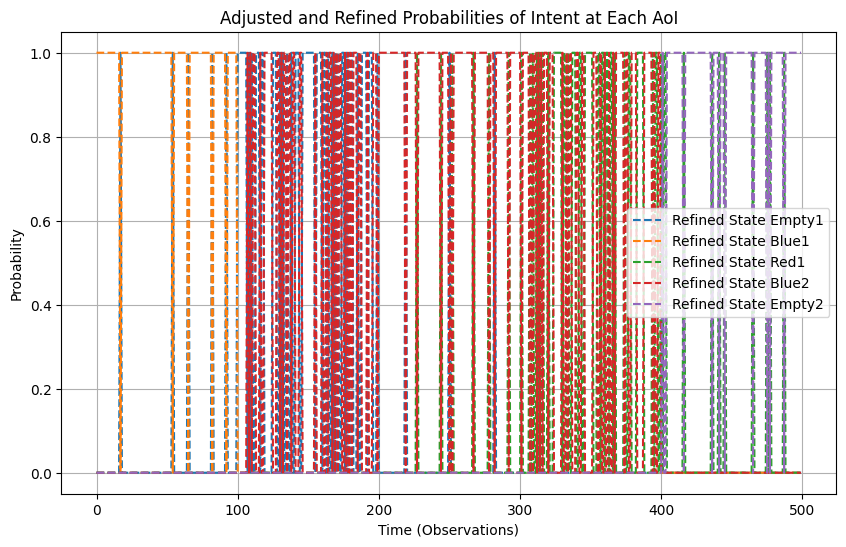

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# # Define Areas of Interest (AoIs) and simulated gaze data
# AoIs = np.array([[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]])  # 5 AoIs
# np.random.seed(42)
# gaze_points = np.random.normal(loc=2, scale=1, size=(100, 2))  # Gaze points centered around red block

# # Calculate initial likelihoods
# def calculate_likelihoods(gaze_points, AoIs):
#     likelihoods = np.zeros((len(gaze_points), len(AoIs)))
#     for i, AoI in enumerate(AoIs):
#         distances = np.linalg.norm(gaze_points - AoI, axis=1)
#         likelihoods[:, i] = 1 / (distances + 1e-5)  # Avoid division by zero
#     likelihoods /= likelihoods.sum(axis=1, keepdims=True)
#     return likelihoods

# likelihoods = calculate_likelihoods(gaze_points, AoIs)

# Adjust likelihoods with task-specific priors
def adjust_likelihoods_with_priors(likelihoods, state):
    if state == 'pick':
        # Increase likelihood for red block, decrease for empty slots
        likelihoods[:, 2] *= 1.5  # Red block
        likelihoods[:, [0, 4]] *= 0.5  # Empty slots
    elif state == 'place':
        # Increase likelihood for empty slots
        likelihoods[:, [0, 4]] *= 1.5
    likelihoods /= likelihoods.sum(axis=1, keepdims=True)
    return likelihoods

state = 'place'  # Example state
adjusted_likelihoods = adjust_likelihoods_with_priors(normalized_likelihood_3, state)

# Define and fit the HMM
model = hmm.GaussianHMM(n_components=5, covariance_type="full", n_iter=100)
model.startprob_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
model.transmat_ = np.array([
    [0.5, 0.125, 0.125, 0.125, 0.125],
    [0.125, 0.5, 0.125, 0.125, 0.125],
    [0.125, 0.125, 0.5, 0.125, 0.125],
    [0.125, 0.125, 0.125, 0.5, 0.125],
    [0.125, 0.125, 0.125, 0.125, 0.5]
])

# Treat adjusted likelihoods as "observations" for the HMM
model.fit(np.atleast_2d(np.argmax(adjusted_likelihoods, axis=1)).T)  # Fit HMM to the most likely AoI sequence

# Predict refined states
refined_states = model.predict(np.atleast_2d(np.argmax(adjusted_likelihoods, axis=1)).T)

# Visualization
plt.figure(figsize=(10, 6))
time_points = np.arange(500)
labels = ['Empty1', 'Blue1', 'Red1', 'Blue2', 'Empty2']
for i in range(5):
    # plt.plot(time_points, adjusted_likelihoods[:, i], label=f'Prob {labels[i]} (adjusted)')
    plt.plot(time_points, (refined_states == i).astype(int), label=f'Refined State {labels[i]}', linestyle='--')

plt.xlabel('Time (Observations)')
plt.ylabel('Probability')
plt.title('Adjusted and Refined Probabilities of Intent at Each AoI')
plt.legend()
plt.grid(True)
plt.show()



Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 5 95  0  0  0  0]
 [57  0  0 43  0  0]
 [ 3  0  6 91  0  0]
 [ 0  0 47 53  0  0]
 [ 0  0 11  0 89  0]]


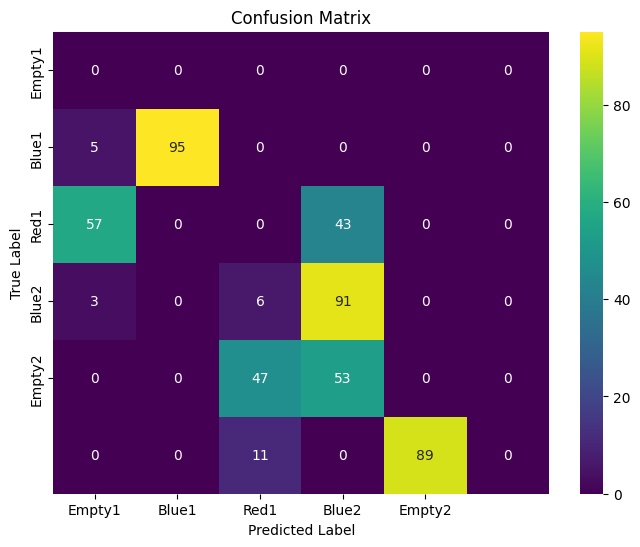

In [238]:
# conf_matrix = compute_confusion_matrix(true_labels, predicted_labels_3)
# plot_confusion_matrix(conf_matrix)
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Optional for better visualization

# Compute the confusion matrix
# predicted_labels_3_adjusted = np.argmax(adjusted_likelihoods, axis=1) + 1  # Shift index from 0-3 to 1-4
# cm = confusion_matrix(true_labels, predicted_labels_3_adjusted)
cm = confusion_matrix(true_labels, refined_states)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["Empty1", "Blue1", "Red1", "Blue2","Empty2"], yticklabels=["Empty1", "Blue1", "Red1", "Blue2","Empty2"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
